In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf

2024-03-20 19:30:31.188460: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 19:30:31.544704: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 19:30:33.074392: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-03-20 19:30:33.075103: W tensorflow/compiler/xla/stre

In [4]:
import json
import sys

In [5]:
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [6]:
import matplotlib.pyplot as plt

In [7]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.param_solver import (
    KoopmanBilinearDLSolver,
    KoopmanLinearDLSolver,
    KoopmanParametricDLSolver,
)
from koopmanlib.target import VanderPolMathieuTarget

In [8]:
config_file = "config_vdpm.json"


with open(config_file, "r") as f:
    config = json.load(f)

data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]

index = 4
n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]
mu = config["data_settings"]["mu"][index]

n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"][index]

In [9]:
dict_layer_size

[64, 64]

In [10]:
print("mu", mu)
print("K_layer_size", K_layer_size)

mu 4
K_layer_size [128]


In [11]:
target_dim = 2
param_dim = 1

n_psi = 1 + target_dim + n_psi_train

In [12]:
n_psi

13

In [13]:
# Set parameters in the vdpm equation.
k1, k2, k4, w0 = 2, 2, 1, 1

In [14]:
vdp_mathieu = VanderPolMathieuTarget(
    mu=mu, dim=target_dim, param_dim=param_dim, k1=k1, k2=k2, k4=k4, w0=w0
)

In [15]:
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [16]:
from koopmanlib.K_structure import Model_K_u_Layer_One

model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="tanh")

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

2024-03-20 19:30:41.229292: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-03-20 19:30:41.229435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-03-20 19:30:41.229444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-03-20 19:30:41.229881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.239.6
2024-03-20 19:30:41.230009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.239.6
2024-03-20 19:30:41.230023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.239.6
2024-03-20 19:30:41.234109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep 

In [17]:
model_pk.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 tf.slice (TFOpLambda)          (None, 1)            0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 tf.ones_like (TFOpLambda)      (None, 1)            0           ['tf.slice[0][0]']               
                                                                                              

In [18]:
model_pk.load_weights(os.path.join(weights_path, "model_pk_vdpm_mu_" + str(mu) + ".h5"))

In [19]:
# model_pk.get_layer('DicNN').trainable = False
# for layer in solver_pk.model_K_u.hidden_layers:
#     layer.trainable = False
# solver_pk.model_K_u.output_layer.trainable = True
# model_pk.load_weights(os.path.join(weights_path, 'train_dense_model_pk_vdpm_mu_'+str(mu)+'.h5'))

# Linear Model: Dynamics is $Az +Bu$

In [20]:
dic_linear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [21]:
solver_linear = KoopmanLinearDLSolver(
    dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)
model_linear, model_K_u_pred_linear = solver_linear.build_model()

In [22]:
model_linear.load_weights(os.path.join(weights_path, "model_linear_vdpm_mu_" + str(mu) + ".h5"))

# Bilinear Model: Dynamics is $Az + \sum_{i=1}^{N_{u}}B_{i}zu_{i}$

In [23]:
dic_bilinear = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)

In [24]:
solver_bilinear = KoopmanBilinearDLSolver(
    dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)
model_bilinear, model_K_u_pred_bilinear = solver_bilinear.build_model()

In [25]:
model_bilinear.load_weights(
    os.path.join(weights_path, "model_bilinear_vdpm_mu_" + str(mu) + ".h5")
)

In [26]:
model_K_u_pred_bilinear.summary()

Model: "K_u_bilinear_pred"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 13)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 tf.einsum (TFOpLambda)         (1, None, 13)        0           ['input_12[0][0]',               
                                                                  'input_11[0][0]']               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 13)          0           ['tf.einsum[0][0]

In [27]:
dict_data = np.load(
        os.path.join(data_path, "vdpm_data_mu_" + str(mu) + ".npy"), allow_pickle=True
    )

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]

In [28]:
data_x.shape

(50000, 2)

<!-- # Train PK-NN using data generated from Bi-linear model
dict_data = np.load(
        os.path.join(data_path, "vdpm_data_mu_" + str(mu) + ".npy"), allow_pickle=True
    )

data_x = dict_data[()]["data_x"]
data_y = dict_data[()]["data_y"]
data_u = dict_data[()]["data_u"]

print("data_x.shape = ", data_x.shape)
data_y_bilinear = []
for data_x_single, data_u_single in zip(data_x, data_u):
    data_y_bilinear_single = solver_bilinear.compute_data_list(
            traj_len=2, data_x_init=data_x_single, data_u=data_u_single
        )
    data_y_bilinear.append(data_y_bilinear_single[-1])

data_y_bilinear = np.array(data_y_bilinear)
data_y_bilinear.shape
# PK-NN
dic_pk = PsiNN(layer_sizes=dict_layer_size, n_psi_train=n_psi_train)
from koopmanlib.K_structure import Model_K_u_Layer, Model_ResNet_K_u_Layer_One

model_K_u = Model_ResNet_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="tanh")

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()


model_pk.compile(optimizer=Adam(0.001), loss="mse")

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.1,
    patience=100,
    verbose=0,
    mode="auto",
    min_delta=1e-4,
    cooldown=0,
    min_lr=1e-6,
)

# Define the early stopping criteria
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=1e-12, patience=50, verbose=1, mode="auto"
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(weights_path, "model_pk_vdpm_mu_" + str(mu) + ".h5"),
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    save_freq="epoch",
)

from tqdm.keras import TqdmCallback
# Define the TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=1)

# Add early_stopping to the list of callbacks
callbacks = [lr_callback, checkpoint_callback, tqdm_callback]

zeros_data_y_train = tf.zeros_like(dic_pk(data_y_bilinear))


history = model_pk.fit(
    x=[data_x, data_y_bilinear, data_u],
    y=zeros_data_y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=200,
    callbacks=callbacks,
    verbose=0,
)
data_pk_pred_from_bilinear = model_pk([data_x, data_y_bilinear, data_u])
data_y_pk_fake = []
for data_x_single, data_u_single in zip(data_x, data_u):
    data_y_pk_fake_single = solver_pk.compute_data_list(
            traj_len=2, data_x_init=data_x_single, data_u=data_u_single
        )
    data_y_pk_fake.append(data_y_pk_fake_single[-1])

data_y_pk_fake = np.array(data_y_pk_fake)
data_y_pk_fake - data_y_bilinear
data_y_pk_fake - data_y -->

In [29]:


# # Train K(u) to be (A+Bu)
# psi_x_data = dic_bilinear(data_x)
# target = model_K_u_pred_bilinear([data_u, psi_x_data])
# inputs_u = Input(shape=(param_dim,))
# inputs_psi_x = Input(shape=(n_psi,))

# fake_psi = model_K_u_pred_pk([inputs_u, inputs_psi_x])

# test_K_model = Model(inputs=[inputs_u, inputs_psi_x], outputs=fake_psi)

# test_K_model.compile(optimizer=Adam(0.000001), loss="mse")
# test_K_model.fit(x=[data_u, psi_x_data], y=target, epochs=500, batch_size=200, verbose=1)
# dic_pk.set_weights(dic_bilinear.get_weights())



## Prediction

In [30]:
from koopmanlib.functions import *

## Calculate average value

In [31]:
np.random.seed(625)
n_test = 20
seed_x_list = np.random.randint(1, 300, size=(n_test,))
seed_param_list = np.random.randint(1, 300, size=(n_test,))
n_traj_test = 1
traj_len_test = 50

In [32]:
ratio_pk_list = []
ratio_linear_list = []
ratio_bilinear_list = []
ratio_dmdc_list = []

In [33]:
data_pred_list_pk_group = []
data_pred_list_linear_group = []
data_pred_list_bilinear_group = []
data_true_group = []
data_pred_list_dmdc_group = []

In [34]:
for seed_x, seed_param in zip(seed_x_list, seed_param_list):
    vdp_mathieu_test = VanderPolMathieuTarget(
        mu=mu, dim=target_dim, param_dim=param_dim, k1=k1, k2=k2, k4=k4, w0=w0
    )

    data_x_test, data_u_test = vdp_mathieu_test.generate_init_data(
        n_traj=n_traj_test, traj_len=traj_len_test, seed_x=seed_x, seed_param=seed_param
    )
    data_x_init = tf.reshape(data_x_test[0], shape=(1, -1))
    data_true = data_x_test

    data_pred_list_pk = solver_pk.compute_data_list(traj_len_test, data_x_init, data_u_test)
    data_pred_list_linear = solver_linear.compute_data_list(
        traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    )
    data_pred_list_bilinear = solver_bilinear.compute_data_list(
        traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    )

    # data_pred_list_dmdc = solver_dmdc.compute_data_list(
    #     traj_len=traj_len_test, data_x_init=data_x_init, data_u=data_u_test
    # )

    ratio_pk = compute_diff_ratio_one_traj(data_true, data_pred_list_pk)
    ratio_linear = compute_diff_ratio_one_traj(data_true, data_pred_list_linear)
    ratio_bilinear = compute_diff_ratio_one_traj(data_true, data_pred_list_bilinear)
    # ratio_dmdc = compute_diff_ratio_one_traj(data_true, data_pred_list_dmdc)

    ratio_pk_list.append(ratio_pk)
    ratio_linear_list.append(ratio_linear)
    ratio_bilinear_list.append(ratio_bilinear)
    # ratio_dmdc_list.append(ratio_dmdc)

    data_pred_list_pk_group.append(data_pred_list_pk)
    data_pred_list_linear_group.append(data_pred_list_linear)
    data_pred_list_bilinear_group.append(data_pred_list_bilinear)
    # data_pred_list_dmdc_group.append(data_pred_list_dmdc)
    data_true_group.append(data_true)

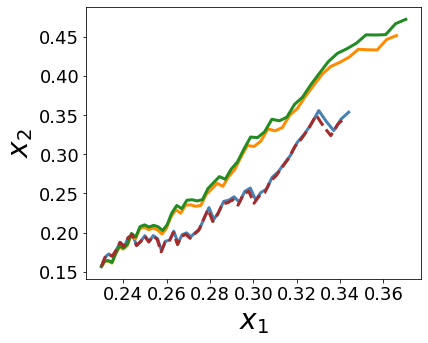

In [35]:
plt.figure(figsize=(6, 5))
plt.plot(
    data_pred_list_pk[:, 0], data_pred_list_pk[:, 1], label="Ours", color="steelblue", linewidth=3
)
plt.plot(
    data_pred_list_linear[:, 0],
    data_pred_list_linear[:, 1],
    label="M2",
    color="darkorange",
    linewidth=3,
)
plt.plot(
    data_pred_list_bilinear[:, 0],
    data_pred_list_bilinear[:, 1],
    label="M3",
    color="forestgreen",
    linewidth=3,
)

# plt.plot(
# data_pred_list_dmdc[:,0],
# data_pred_list_dmdc[:,1],
# label='DMDc',
# color='red',
# linewidth=3
# )
plt.plot(
    data_true[:, 0], data_true[:, 1], label="True", color="brown", linestyle="dashed", linewidth=3
)
plt.xlabel(r"$x_{1}$", fontsize=28)
plt.ylabel(r"$x_{2}$", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

plt.savefig(os.path.join(figures_path, 'traj_vdpm_'+str(mu)+'_.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figures_path, 'traj_vdpm_'+str(mu)+'_.pdf'), dpi=200, bbox_inches='tight')


In [36]:
data_pred_list_pk_group = np.asarray(data_pred_list_pk_group)
data_pred_list_linear_group = np.asarray(data_pred_list_linear_group)
data_pred_list_bilinear_group = np.asarray(data_pred_list_bilinear_group)
data_true_group = np.asarray(data_true_group)

In [37]:
# for i in range(data_pred_list_pk_group.shape[0]):
#     plt.figure(figsize=(6, 5))
#     plt.plot(
#         data_pred_list_pk_group[i, :, 0],
#         data_pred_list_pk_group[i, :, 1],
#         label="Ours",
#         color="steelblue",
#         linewidth=3,
#     )
#     plt.plot(
#         data_pred_list_linear_group[i, :, 0],
#         data_pred_list_linear_group[i, :, 1],
#         label="M2",
#         color="darkorange",
#         linewidth=3,
#     )
#     plt.plot(
#         data_pred_list_bilinear_group[i, :, 0],
#         data_pred_list_bilinear_group[i, :, 1],
#         label="M3",
#         color="forestgreen",
#         linewidth=3,
#     )
#     plt.plot(
#         data_true_group[i, :, 0],
#         data_true_group[i, :, 1],
#         label="True",
#         color="brown",
#         linestyle="dashed",
#         linewidth=3,
#     )
#     plt.xlabel(r"$x_{1}$", fontsize=28)
#     plt.ylabel(r"$x_{2}$", fontsize=28)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=18)
#     plt.legend(fontsize=18)

In [38]:
ratio_pk_list = np.asarray(ratio_pk_list)
ratio_linear_list = np.asarray(ratio_linear_list)
ratio_bilinear_list = np.asarray(ratio_bilinear_list)

In [39]:
ratio_pk_list_mean = np.mean(ratio_pk_list, axis=0)
ratio_linear_list_mean = np.mean(ratio_linear_list, axis=0)
ratio_bilinear_list_mean = np.mean(ratio_bilinear_list, axis=0)

In [40]:
ratio_linear_list_mean

array([0.        , 0.01083291, 0.01430431, 0.0178938 , 0.02100735,
       0.02315006, 0.02409157, 0.02518721, 0.02601465, 0.02709635,
       0.02837726, 0.02934231, 0.03028863, 0.03135387, 0.03240472,
       0.03346037, 0.03431658, 0.03546356, 0.03631908, 0.03764959,
       0.03869702, 0.03964907, 0.04020112, 0.04095592, 0.04194191,
       0.04272115, 0.04341536, 0.04430872, 0.04524251, 0.04639864,
       0.04796234, 0.04926283, 0.0507874 , 0.05208575, 0.05331993,
       0.05479   , 0.05609994, 0.05741957, 0.05843383, 0.05956355,
       0.06068314, 0.06164141, 0.06249608, 0.06339699, 0.06412656,
       0.06465082, 0.06536755, 0.0659852 , 0.06666389, 0.06732033])

In [41]:
ratio_pk_list_median = np.median(ratio_pk_list, axis=0)
ratio_linear_list_median = np.median(ratio_linear_list, axis=0)
ratio_bilinear_list_median = np.median(ratio_bilinear_list, axis=0)

In [42]:
q_min = 0.35
q_max = 0.65

In [43]:
ratio_pk_list_min = np.quantile(ratio_pk_list, q=q_min, axis=0)
ratio_linear_list_min = np.quantile(ratio_linear_list, q=q_min, axis=0)
ratio_bilinear_list_min = np.quantile(ratio_bilinear_list, q=q_min, axis=0)

In [44]:
ratio_pk_list_max = np.quantile(ratio_pk_list, q=q_max, axis=0)
ratio_linear_list_max = np.quantile(ratio_linear_list, q=q_max, axis=0)
ratio_bilinear_list_max = np.quantile(ratio_bilinear_list, q=q_max, axis=0)

In [45]:
x_axis = np.arange(0, traj_len_test, 1)

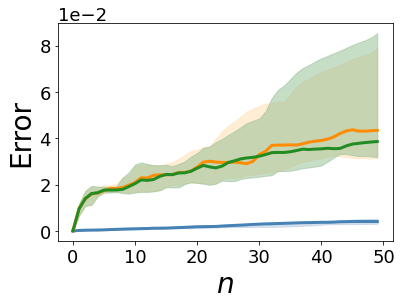

In [46]:
plt.figure(figsize=(6, 4))

plt.plot(ratio_pk_list_median, label="Ours", color="steelblue", linewidth=3)
plt.fill_between(x_axis, ratio_pk_list_min, ratio_pk_list_max, color="lightsteelblue", alpha=0.5)
plt.plot(ratio_linear_list_median, label="M2", color="darkorange", linewidth=3)
plt.fill_between(
    x_axis, ratio_linear_list_min, ratio_linear_list_max, color="navajowhite", alpha=0.5
)
plt.plot(ratio_bilinear_list_median, label="M3", color="forestgreen", linewidth=3)
plt.fill_between(
    x_axis, ratio_bilinear_list_min, ratio_bilinear_list_max, color="darkseagreen", alpha=0.5
)


plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.gca().yaxis.get_offset_text().set_fontsize(18)

plt.xlabel(r"$n$", fontsize=28)
plt.ylabel("Error", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.legend(fontsize=18)

plt.savefig(os.path.join(figures_path, 'error_vdpm_'+str(mu)+'_.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figures_path, 'error_vdpm_'+str(mu)+'_.pdf'), dpi=200, bbox_inches='tight')


In [47]:
dict_mean = {
    "pk": ratio_pk_list_mean,
    "linear": ratio_linear_list_mean,
    "bilinear": ratio_bilinear_list_mean,
}

In [48]:
np.save(os.path.join(data_path, "ratio_list_dict_mu_" + str(mu) + "_mean.npy"), dict_mean)